In [33]:
%matplotlib widget

In [1]:
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
import numpy as np
from ephysvibe.task import task_constants,def_task
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [3]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

In [49]:
def compute_neuron_avr(data,bhv):
    t_before = 200
    t_after = 850
    in_out='in'
    cgroup='good'
    e_align="sample_on"
    # select correct trials in block 1 (DMT)
    trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
    # check the in out correction
    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    # define task frame
    task = def_task.create_task_frame(
        condition=bhv.condition[trials_b1],
        test_stimuli=bhv.test_stimuli[trials_b1],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    # select cluster group
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]
    if neurons.shape[0] == 0:
        return np.nan
    # select trials with the condition in_out
    task = task[np.logical_and(np.in1d(task['i_neuron'].values,neurons),task['in_out']==in_out)]
    # split in two groups where the neurons in each have the same trials in in or out
    task_1 = task[task['i_neuron']==neurons[0]].copy()
    trials_neuron = task_1['trial_idx'].values
    task_1['trial_idx'] = task_1['trial_idx'].replace(trials_neuron,np.arange(0,len(trials_neuron)))
    t_neurons = task[np.in1d(task['trial_idx'].values,trials_neuron)]['i_neuron'].unique()
    t_neurons_2=neurons[~np.in1d(neurons,t_neurons)]
    task_all = [task_1]
    if len(t_neurons_2) != 0:
        trials_neuron_2 = task[task['i_neuron']==t_neurons_2[0]]['trial_idx'].values
        trials_neuron = [trials_neuron,trials_neuron_2]
        t_neurons = [t_neurons,t_neurons_2]
        task_2 = task[task['i_neuron']==t_neurons_2[0]].copy()
        task_2['trial_idx'] = task_2['trial_idx'].replace(trials_neuron_2,np.arange(0,len(trials_neuron_2)))
        task_all = [task_1,task_2]
    else:
        trials_neuron = [trials_neuron]
        t_neurons = [t_neurons]

    sp_avg_all = []
    for i_task, (trial_idx_n, neurons,task) in enumerate(zip(trials_neuron,t_neurons,task_all)):

        trials_s_on = data.code_samples[
            trials_b1[trial_idx_n],
            np.where(data.code_numbers[trials_b1[trial_idx_n]] == task_constants.EVENTS_B1[e_align])[
                1
            ],
        ]
        shifts = -(trials_s_on - t_before).astype(int)
        shifts = shifts[:,np.newaxis]
        shift_sp = SpikeData.indep_roll(data.sp_samples[trials_b1[trial_idx_n]][:,neurons], shifts, axis=2)[:,:, :t_before+t_after]
        #sp_avg = moving_average(shift_sp, win=win, step=step)
        #sp_avg = np.mean(shift_sp,axis=0)
        sp_avg_all.append(shift_sp)
    # average activity of each neuron for each sample 
    sp_avg = []
    for i_samp in ['o1_c1', 'o1_c5', 'o5_c1', 'o5_c5']:#, 'o0_c0'
        i_t=task_all[0][task_all[0]['sample']==i_samp]['trial_idx'].values
        sp_avg.append(np.mean(sp_avg_all[0][i_t],axis=0))
    sp_avg=np.concatenate(sp_avg,axis=1)

    return sp_avg

In [15]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_decoding.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

In [44]:
4200/4

1050.0

In [59]:
sp_avg_all=[]
for n_bhv,n_sp in zip(paths_bhv,paths_sp):
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    
    neus_avg = compute_neuron_avr(data,bhv)
    if np.any(np.isnan(np.array(neus_avg))):
        print(n_bhv)
        continue
    
    sp_avg_all.append(neus_avg)
sp_avg = np.concatenate(sp_avg_all,axis=0)



/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-11-30_10-42-03_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-06_11-12-04_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-14_10-50-49_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-03_10-59-32_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-06_10-38-57_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-09_11-13-27_Riesling_e1_r1_bhv.h5


In [41]:
sp_avg_all[1].shape

IndexError: list index out of range

In [40]:
np.concatenate(sp_avg_all,axis=0)

array([[0.01041667, 0.        , 0.        , ..., 0.01515152, 0.        ,
        0.01515152],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
# sp_avg_all=[]
# n_sp='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-10-10_10-41-43_Riesling_lip_e1_r1_sp.h5'
# data = SpikeData.from_python_hdf5(n_sp)
# n_bhv='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-10_10-41-43_Riesling_e1_r1_bhv.h5'
# bhv = BhvData.from_python_hdf5(n_bhv)
# print(n_bhv)
# sp_avg_all.append(compute_neuron_avr(data,bhv))

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-10_10-41-43_Riesling_e1_r1_bhv.h5


In [53]:
sp_avg_lip = sp_avg
sp_avg_v4 = sp_avg
sp_avg_pfc = sp_avg

In [8]:
np.save('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_v4_good.npy',sp_avg)

In [9]:
sp_avg_pfc = np.load('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_pfc_good.npy')
sp_avg_v4 = np.load('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_v4_good.npy')
sp_avg_lip = np.load('/home/INT/losada.c/Documents/codes/EphysVibe/examples/pca_lip_good.npy')

In [54]:
print(sp_avg_pfc.shape,sp_avg_v4.shape,sp_avg_lip.shape)

(139, 4200) (139, 4200) (139, 4200)


In [11]:
4200/4

1050.0

In [55]:
def compute_pca(sp_avg,n_comp):
    # perform PCA
    #sp_avg = sp_avg[:,2200:]
    sp_avg_z = z_score(sp_avg)
    model = PCA(n_components=n_comp).fit(sp_avg_z.T)
    C = model.components_
    pc_s = C @ sp_avg_z
    model
    #print(pc_s.shape)
    return model,pc_s

In [56]:
def plot_pcs(mean_co_pcs,n_pcs,area):
    fix_idx = np.arange(0,100,2)
    fix2_idx = np.arange(100,200,2)
    samp1_idx = np.arange(200,400,2)
    samp2_idx = np.arange(400,650,2)
    delay_idx = np.arange(650,1000,2)

    for i in np.arange(0,1,2):
        fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True,sharex=True)#, subplot_kw={'projection': '3d'}
        
        ax[0].plot(mean_co_pcs[i][fix_idx],mean_co_pcs[i+1][fix_idx],label='fixation')
        ax[0].plot(mean_co_pcs[i][fix2_idx],mean_co_pcs[i+1][fix2_idx],label='fixation2')
        ax[0].plot(mean_co_pcs[i][samp1_idx],mean_co_pcs[i+1][samp1_idx],label='sample first part')
        ax[0].plot(mean_co_pcs[i][samp2_idx],mean_co_pcs[i+1][samp2_idx],label='sample 2nd part')
        ax[0].plot(mean_co_pcs[i][delay_idx],mean_co_pcs[i+1][delay_idx],label='delay')
        
        ax[1].plot(n_pcs[i][fix_idx],n_pcs[i+1][fix_idx],label='fixation')
        ax[1].plot(n_pcs[i][fix2_idx],n_pcs[i+1][fix2_idx],label='fixation2')
        ax[1].plot(n_pcs[i][samp1_idx],n_pcs[i+1][samp1_idx],label='sample first ms')
        ax[1].plot(n_pcs[i][samp2_idx],n_pcs[i+1][samp2_idx],label='sample 2nd ms')
        ax[1].plot(n_pcs[i][delay_idx],n_pcs[i+1][delay_idx],label='delay')

        fig.suptitle(area)
        ax[0].set(xlabel="PC "+str(i), ylabel="PC "+str(i+1))
        ax[1].set(xlabel="PC "+str(i), ylabel="PC "+str(i+1))
        ax[1].legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper right')

In [24]:
co_pcs.shape

(144, 1050)

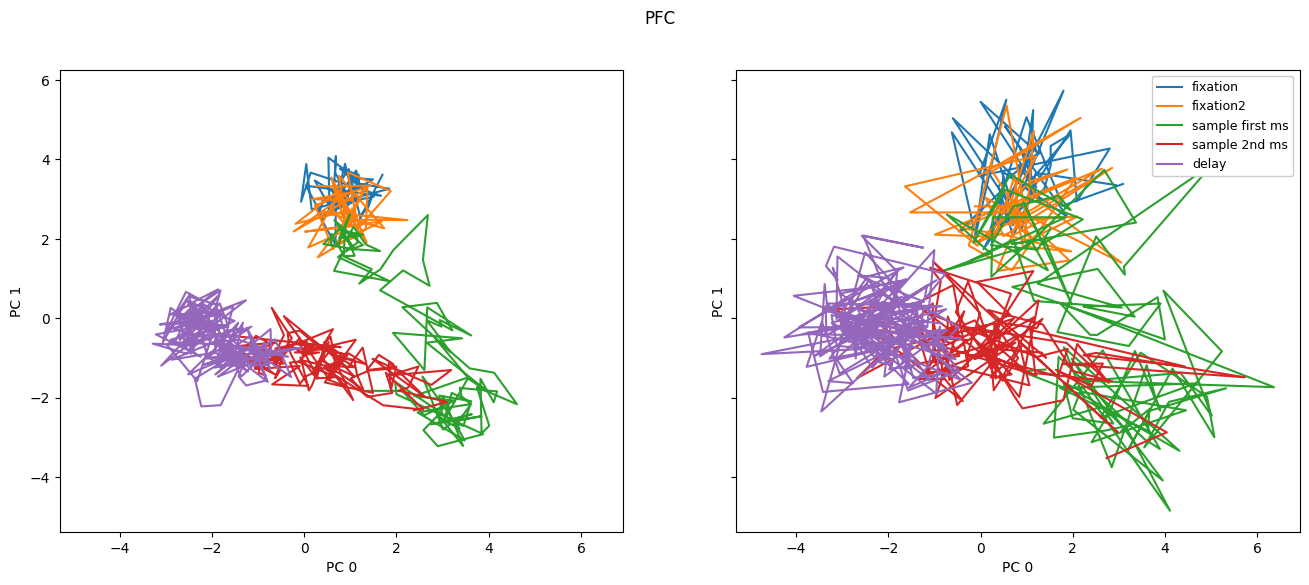

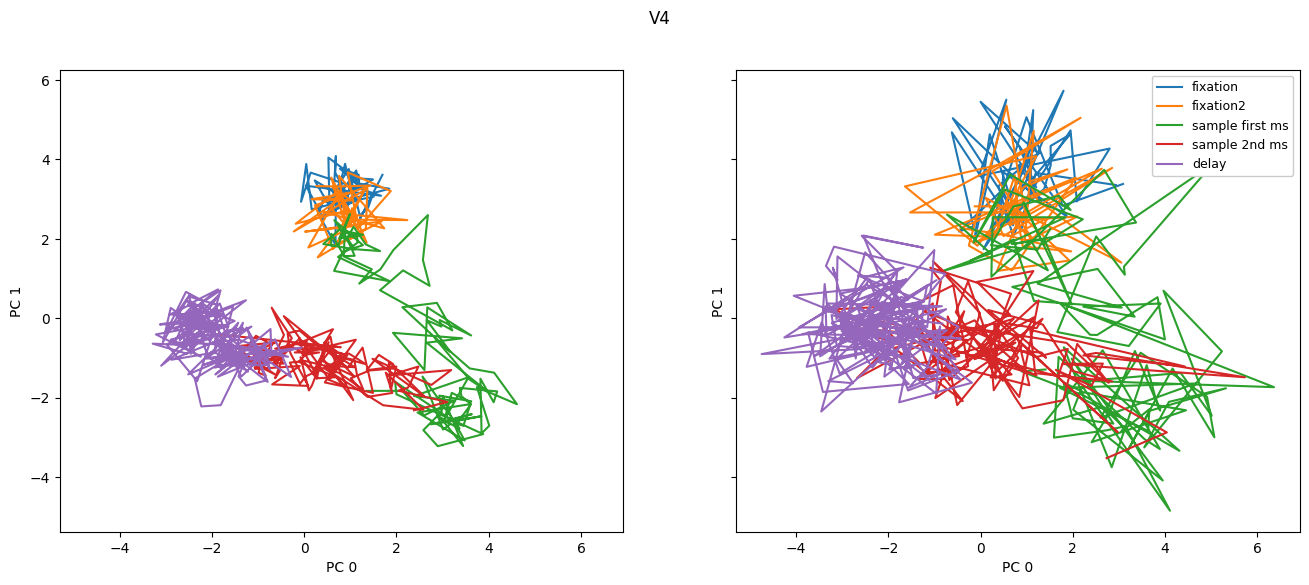

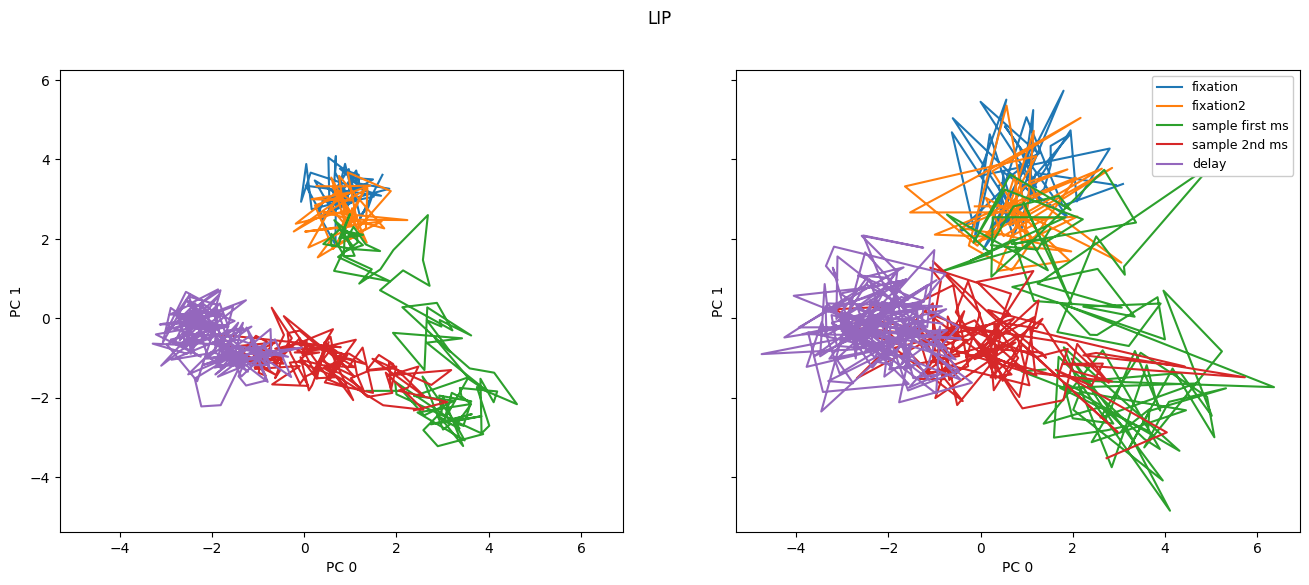

In [58]:
n_comp = 139
all_model = []
for sp_avg,area in zip([sp_avg_pfc,sp_avg_v4,sp_avg_lip],['PFC','V4','LIP']):
    model,pc_s = compute_pca(sp_avg,n_comp)
    all_model.append(model)
    reshape_pc_s = pc_s.reshape(n_comp,-1,1050)
    co_pcs = reshape_pc_s[:,:,:]
    n_pcs = reshape_pc_s[:,3,:]
    mean_co_pcs = np.mean(co_pcs,axis=1)
    plot_pcs(mean_co_pcs,n_pcs,area)

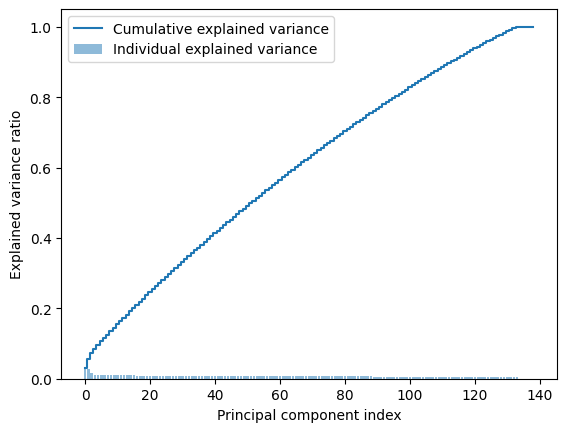

In [60]:
fig,ax = plt.subplots()
exp_var_pca = all_model[0].explained_variance_ratio_
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [29]:
def plot3d_pcs(mean_co_pcs,n_pcs,area):
    fix_idx = np.arange(0,100,2)
    fix2_idx = np.arange(100,200,2)
    samp1_idx = np.arange(200,400,2)
    samp2_idx = np.arange(400,650,2)
    delay_idx = np.arange(650,1000,2)

    for i in np.arange(0,1,2):
        fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True,sharex=True, subplot_kw={'projection': '3d'})#
        
        ax[0].plot(mean_co_pcs[i][fix_idx],mean_co_pcs[i+1][fix_idx],mean_co_pcs[i+2][fix_idx],label='fixation')
        ax[0].plot(mean_co_pcs[i][fix2_idx],mean_co_pcs[i+1][fix2_idx],mean_co_pcs[i+2][fix2_idx],label='fixation2')
        ax[0].plot(mean_co_pcs[i][samp1_idx],mean_co_pcs[i+1][samp1_idx],mean_co_pcs[i+2][samp1_idx],label='sample first part')
        ax[0].plot(mean_co_pcs[i][samp2_idx],mean_co_pcs[i+1][samp2_idx],mean_co_pcs[i+2][samp2_idx],label='sample 2nd part')
        ax[0].plot(mean_co_pcs[i][delay_idx],mean_co_pcs[i+1][delay_idx],mean_co_pcs[i+2][delay_idx],label='delay')
        
        ax[1].plot(n_pcs[i][fix_idx],n_pcs[i+1][fix_idx],n_pcs[i+2][fix_idx],label='fixation')
        ax[1].plot(n_pcs[i][fix2_idx],n_pcs[i+1][fix2_idx],n_pcs[i+2][fix2_idx],label='fixation2')
        ax[1].plot(n_pcs[i][samp1_idx],n_pcs[i+1][samp1_idx],n_pcs[i+2][samp1_idx],label='sample first ms')
        ax[1].plot(n_pcs[i][samp2_idx],n_pcs[i+1][samp2_idx],n_pcs[i+2][samp2_idx],label='sample 2nd ms')
        ax[1].plot(n_pcs[i][delay_idx],n_pcs[i+1][delay_idx],n_pcs[i+2][delay_idx],label='delay')

        fig.suptitle(area)
        ax[0].set(xlabel="PC "+str(i), ylabel="PC "+str(i+1))
        ax[1].set(xlabel="PC "+str(i), ylabel="PC "+str(i+1))
        ax[1].legend(fontsize=9,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper right')

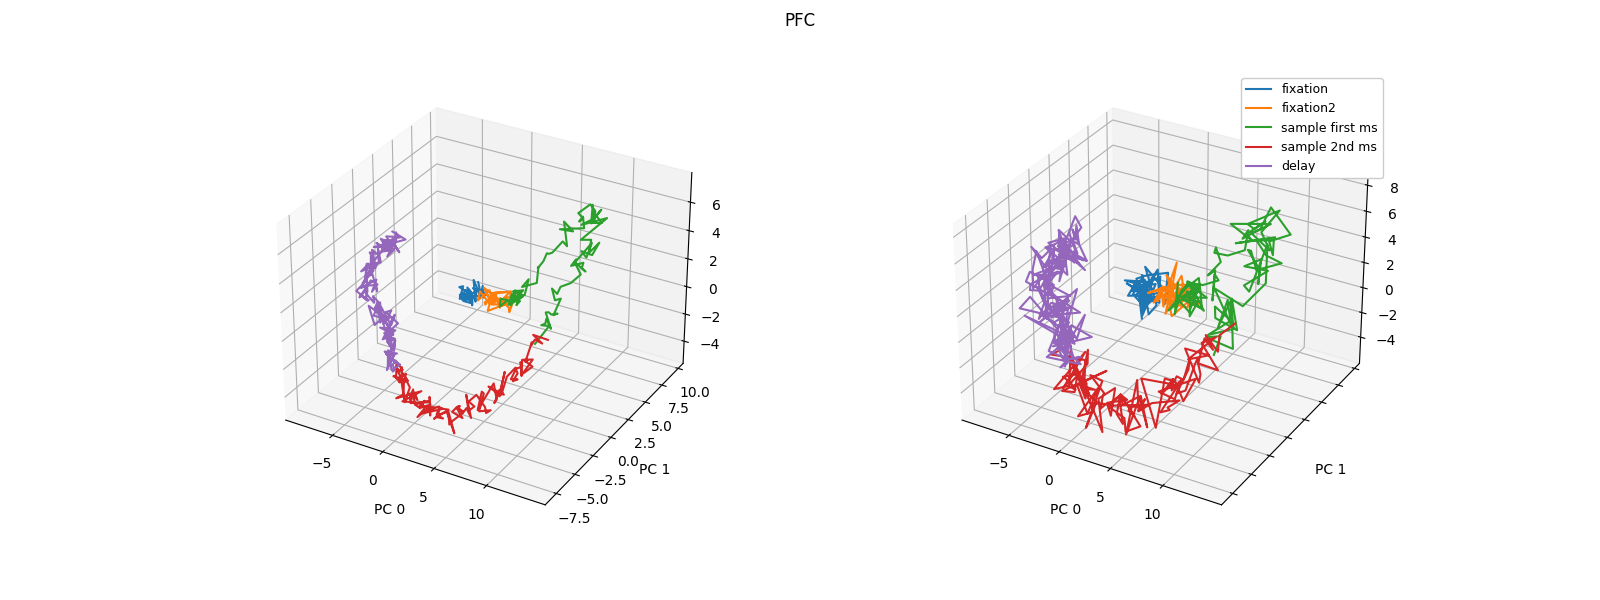

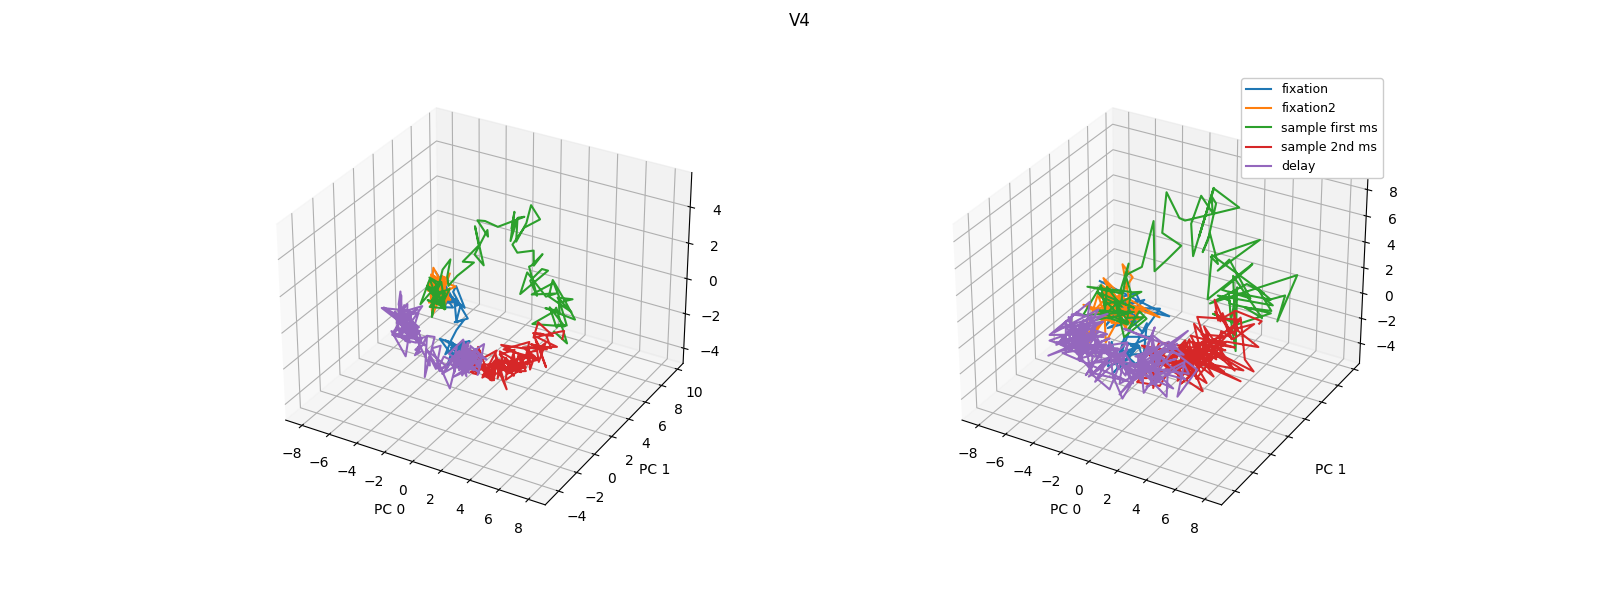

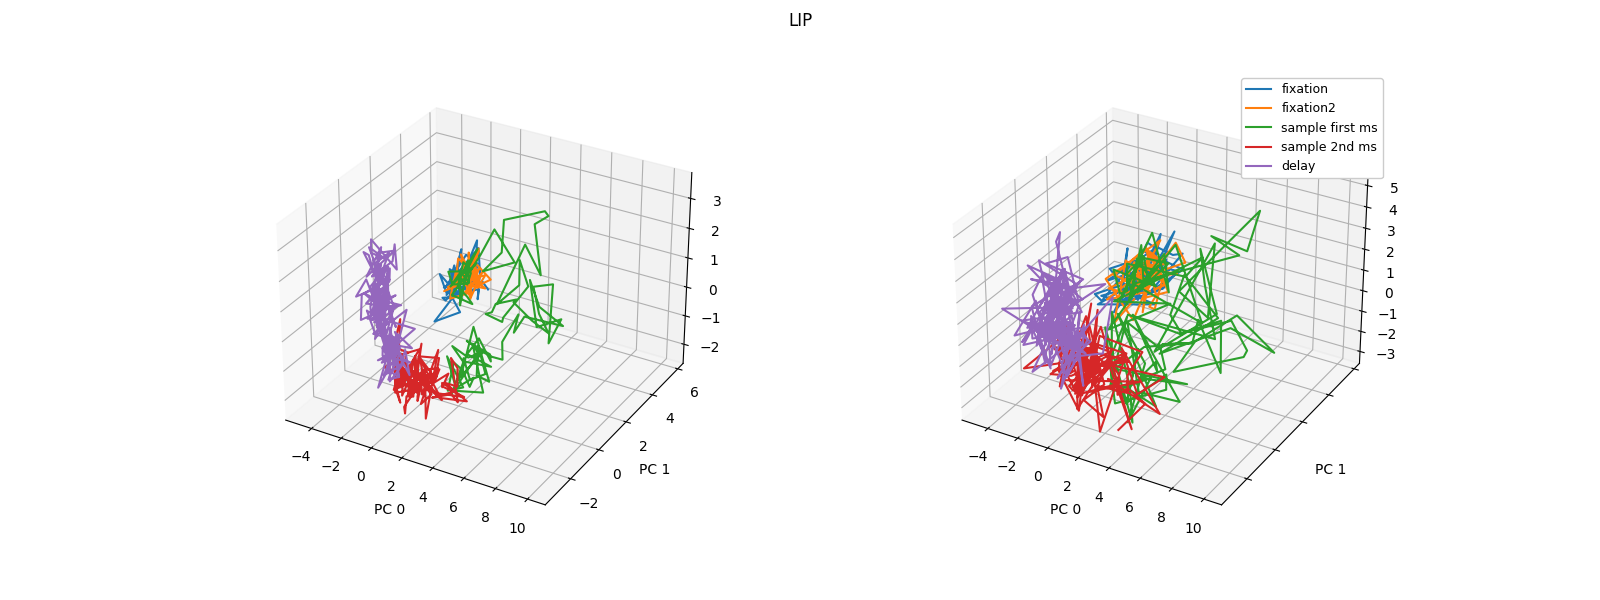

In [34]:
all_model = []
for sp_avg,area in zip([sp_avg_pfc,sp_avg_v4,sp_avg_lip],['PFC','V4','LIP']):#
    model,pc_s = compute_pca(sp_avg,n_comp)
    all_model.append(model)
    reshape_pc_s = pc_s.reshape(144,-1,1050)
    co_pcs = reshape_pc_s[:,:4,:]
    n_pcs = reshape_pc_s[:,-1,:]
    mean_co_pcs = np.mean(co_pcs,axis=1)
    plot3d_pcs(mean_co_pcs,n_pcs,area)